<font color="#CC3D3D"><p>
# [Competition] Building a `DNN` Model with `Pipeline`

####  전역변수 설정

In [1]:
DNN_VERSION = 1.0  # submission 화일명에 사용
SEED = 0           # random_state 지정
NCOMP = 50         # 축소할 차원수
K = 10             # KMeans의 군집수

In [2]:
#!pip install tensorflow

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans  
from sklearn import set_config
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import shap
import re
import random

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.6.4


In [4]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(SEED)
    random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

# 재현을 하기 위해 SEED 고정. 고정시키지 않으면 돌릴때마다 결과가 달라짐.
# 항상 같은 값을 가지려면 전체를 다시 돌려야함.

RANDOM SEEDS RESET


#### 데이터 로딩

In [5]:
X_train = pd.read_csv('/kaggle/input/kml2022f/X_train.csv', encoding='cp949').drop(columns='ID')
y_train = pd.read_csv('/kaggle/input/kml2022f/y_train.csv', encoding='cp949').Salary

X_test = pd.read_csv('/kaggle/input/kml2022f/X_test.csv', encoding='cp949')
test_id = X_test.ID
X_test = X_test.drop(columns='ID')

#### 데이터 클린징

In [6]:
### 경력을 수치로 변환

def f1(x):
    numbers = re.findall(r'\d+', x)
    return int(numbers[0])*12 if len(numbers) == 1 else int(numbers[0])*12+int(numbers[1])

X_train['근무경력'] = X_train['근무경력'].apply(f1)
X_test['근무경력'] = X_test['근무경력'].apply(f1)

#### 유형별 피처 분리

In [7]:
numeric_features = ['근무경력','대학성적']
categorical_features = ['직종','세부직종','출신대학','대학전공','어학시험','자격증']
binary_features = ['직무태그','근무지역','근무형태']

X_train = X_train[numeric_features+categorical_features+binary_features] 
X_test = X_test[numeric_features+categorical_features+binary_features]

####  전처리 파이프라인 구축

- sklearn에 없는 새로운 전처리기 정의

In [8]:
# 상하한값 제한을 통한 결측값 처리 함수: FunctionTransformer를 통해 호출
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

# Shap을 이용한 피처선택 전처리기 클래스
class ShapFeatureSelector(TransformerMixin, BaseEstimator):
    # 전처리기 생성 즉, ShapFeatureSelector() 호출시 실행
    def __init__(self, model):
        self.model = model

    # 전처리기의 fit() 호출시 실행
    def fit(self, X, y):
        X = np.array(X)
        model = self.model.fit(X, y)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        self.shap_sum = np.abs(shap_values).mean(axis=0)
        return self
    
    # 전처리기의 transform() 호출시 실행
    def transform(self, X):
        return X[:,self.shap_sum > 0]        

# 군집분석을 활용한 피처생성 전처리기 클래스
class KMeansFeaturizer(TransformerMixin, BaseEstimator):
    """Transforms numeric data into k-means cluster memberships.
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster.

    Parameters
    ----------
    k: integer, optional, default 10
        The number of clusters to group data into.

    random_state : integer, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.
    """

    def __init__(self, k=10, random_state=None):
        self.k = k
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
        km_model.fit(X)
        self.km_model = km_model
        return self
        
    def transform(self, X, y=None):
        clusters = self.km_model.predict(X)
        new_features = self.cluster_encoder.transform(clusters.reshape(-1,1)).astype(int).todense()
        return np.concatenate([X, new_features], axis=1)

- 파이프라인 구성

In [9]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})),
        ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

binary_transformer = Pipeline(
    steps=[
        ("impuer", FunctionTransformer(lambda x: x.fillna('없음'))),      
        ("corpus", FunctionTransformer(lambda x: x.str.replace('·',',').str.split(',').str.join(" "))),
        ("BoW", CountVectorizer()),
        ("dense", FunctionTransformer(lambda x: x.toarray().astype(int), accept_sparse=True)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin1", make_pipeline(binary_transformer, TruncatedSVD(n_components=NCOMP,random_state=SEED)), binary_features[0]),
        ("bin2", binary_transformer, binary_features[1]),
        ("bin3", binary_transformer, binary_features[2]),
    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("kmf", KMeansFeaturizer(k=K, random_state=SEED)),
        ("select", ShapFeatureSelector(model=LGBMRegressor(random_state=SEED))), 
    ]
)

set_config(display="diagram")
preprocessor

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier',
                                                                   FunctionTransformer(func=<function remove_outlier at 0x7f6a446b9f80>,
                                                                                       kw_args={'q': 0.05})),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['근무경력', '대학성적']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEn...
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f6a446a18c0>)),
                                                                  ('corpus',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f6a446a1950>)),
                                                                  ('BoW',
                                                                   CountVectorizer()),
                                                                  ('dense',
                                                                   FunctionTransformer(accept_sparse=True,
                                                                                       func=<function <lambda> at 0x7f6a446a19e0>))]),
                                                  '근무형태')])),
                ('kmf', KMeansFeaturizer(random_state=0)),
                ('select',
                 ShapFeatureSelector(model=LGBMRegressor(random_state=0)))])

####  데이터 전처리 with 파이프라인

In [10]:
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape)

(16570, 205)


In [11]:
# 뉴롤렛은 원핫인코딩을 주로 씀. 타겟 인코딩이나, 
# 중요한건 데이터를 정규화를 시켜야함.

<font color="blue"><p>
#### DNN 모형 생성

<font color="blue"><p>
- 1단계: 모형 정의하기 (입력층/은익층/출력층 쌓기)

In [12]:
X_train.shape[1]
# 피쳐 수 만큼 input으로 들어감.

205

In [13]:
inputs = keras.Input(shape=X_train.shape[1], )          # 입력층
x = keras.layers.Dense(128, activation='relu')(inputs)  # 첫번째 은익층, Dense는 다 연결하라는 뜻. 은닉층에 있는 뉴런수가 128
x = keras.layers.Dense(64, activation='relu')(x)        # 두번째 은익층
output = keras.layers.Dense(1, activation='linear')(x)  # 출력층, 회귀니깐 뉴런 하나, 회귀 문제는 linear로 (이 말은 활성화함수를 쓰지 않겠다 라는 뜻. 분류는 시그모이드나 다른거 씀.)

model = keras.Model(inputs=inputs, outputs=output)      # 입력층과 출력층을 지정함으로써 전체모형 정의

2022-12-02 18:09:43.743767: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
# 모형 구조 출력: Total params가 많을수록 복잡한 모델임.
model.summary()

# None의 의미는 배치 사이즈에 의해 정해진다. 신경쓸 필요 없음. (입력의 배치 사이즈) 

# 205*128 + 128 = 26368 뒤 128은 Bias임
# 총 3만4천개의 웨이트 학습시켜야함.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 205)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               26368     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________


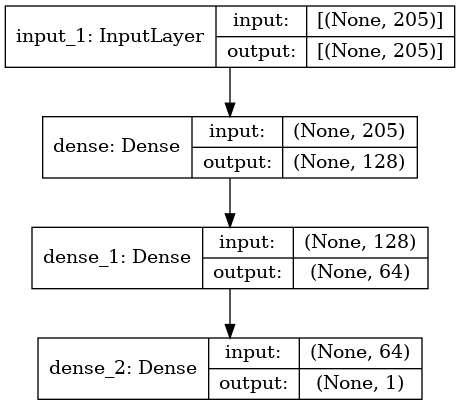

In [15]:
# 연결 그래프 시각화: graphviz와 pydot 설치 필요 (graphviz 다운로드하고 설치한 후 pip install pydot)
keras.utils.plot_model(model, show_shapes=True)

<font color="blue"><p>
- 2단계: 학습방식(손실함수/옵티마이저/평가척도) 설정하기

In [16]:
model.compile(
    loss='mse', # 분류면 크로스엔트로피
    optimizer=keras.optimizers.RMSprop(),  # SGD도 있음.                   
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')] # CV랑 비슷한거임.
)

<font color="blue"><p>
- 3단계: 모형 학습하기 (에포크, 배치사이즈, 조기중단 등 지정) 

In [17]:
hist = model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.1, # DNN 학습시 검증데이터가 필요함. 학습데이터의 10%를 검증데이터로 사용.
    batch_size=64, 
    epochs=200, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)], # 검증데이터의 Loss가 5회연속 감소하지 않으면 학습 중단.
    shuffle=False,       # 재현을 위해 False로 설정.
    verbose=2,
)

# 뉴롤렛은 그래프의 곡선을 봐야함. 따라서 밸리데이션 해야함. 0.1을 평가할 때 쓰겠다.
# 16000/24*200만큼 학습
# callbacks 얼리 스타핑 -> 과적합 빠지지 않게 함.

2022-12-02 18:09:45.070037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
234/234 - 1s - loss: 6943944.0000 - rmse: 2635.1365 - val_loss: 7234373.0000 - val_rmse: 2689.6790
Epoch 2/200
234/234 - 0s - loss: 1556077.8750 - rmse: 1247.4285 - val_loss: 2062705.5000 - val_rmse: 1436.2122
Epoch 3/200
234/234 - 0s - loss: 1070165.6250 - rmse: 1034.4880 - val_loss: 1744948.6250 - val_rmse: 1320.9651
Epoch 4/200
234/234 - 0s - loss: 961385.8750 - rmse: 980.5029 - val_loss: 1634006.7500 - val_rmse: 1278.2827
Epoch 5/200
234/234 - 0s - loss: 915523.5000 - rmse: 956.8299 - val_loss: 1587035.8750 - val_rmse: 1259.7761
Epoch 6/200
234/234 - 0s - loss: 890167.6250 - rmse: 943.4869 - val_loss: 1561763.6250 - val_rmse: 1249.7054
Epoch 7/200
234/234 - 0s - loss: 874143.5625 - rmse: 934.9564 - val_loss: 1545437.5000 - val_rmse: 1243.1562
Epoch 8/200
234/234 - 0s - loss: 863197.2500 - rmse: 929.0841 - val_loss: 1533207.7500 - val_rmse: 1238.2277
Epoch 9/200
234/234 - 0s - loss: 855174.3750 - rmse: 924.7564 - val_loss: 1522997.0000 - val_rmse: 1234.0977
Epoch 10/200


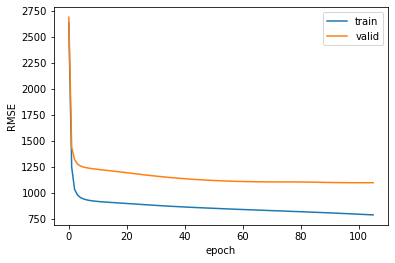

In [18]:
# 러닝커브 그리기: 학습이 잘되었는지 어느정도 판단할 수 있음.

plt.plot(hist.history['rmse'], label="train")
plt.plot(hist.history['val_rmse'], label="valid")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# 학습 데이터 loss는 떨어지고 있지만 vaild는 안떨어지고 있음. 따라서 조기종료

<font color="blue"><p>
- 4단계: 예측하기

In [19]:
# 예측값 얻기: sklearn 과 달리 2차원 array로 출력 => 1차원으로 변경 필요.
pred = model.predict(X_test).flatten()

# submission 화일 생성
filename = f'dnn_{DNN_VERSION}_{hist.history["val_rmse"][-1]:.2f}.csv'
pd.DataFrame({'ID':test_id, 'Salary':pred}).to_csv(filename, index=False)

print(f'{filename} is ready to submit.')

dnn_1.0_1098.66.csv is ready to submit.


<font color="#CC3D3D"><p>
# End